# Описание проекта.

Меня пригласили на стажировку в отдел аналитики Яндекс.Афиши.

Моя задача: помочь маркетологам оптимизировать маркетинговые затраты.

# Описание данных.

Таблица visits (лог сервера с информацией о посещениях сайта):

* Uid — уникальный id пользователя;
* Device — категория устройства пользователя;
* Start Ts — дата и время начала сессии;
* End Ts — дата и время окончания сессии;
* Source Id — идентификатор рекламного источника, из которого пришел пользователь.

Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ;
* Buy Ts — дата и время заказа;
* Revenue — выручка Яндекс.Афиши с этого заказа.

Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника;
* dt — дата;
* costs — затраты на этот рекламный источник в этот день.

# Шаг 1. Загрузите данные и подготовьте их к анализу.

# Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import decimal

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

**Посмотрим общие данные по таблицам.**

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


**Предобработка данных.**

Переименовываем столбцы.

In [9]:
orders.columns = ['buy_time', 'revenue', 'uid']
visits.columns = ['device', 'end_time', 'source_id', 'start_time', 'uid']
costs.columns = ['source_id', 'date', 'costs']

In [10]:
visits['start_time'] = pd.to_datetime(visits['start_time'], format='%Y-%m-%d %H:%M:%S')
visits['end_time'] = pd.to_datetime(visits['end_time'], format='%Y-%m-%d %H:%M:%S')
orders['buy_time'] = pd.to_datetime(orders['buy_time'], format='%Y-%m-%d %H:%M:%S')
costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')

In [11]:
visits['day'] = visits['start_time'].dt.date
orders['day'] = orders['buy_time'].dt.date

In [12]:
visits['start_time_day'] = visits['start_time'].dt.date
visits['start_time_week'] = visits['start_time'].dt.week
visits['start_time_month'] = visits['start_time'].dt.month
visits['start_time_year'] = visits['start_time'].dt.year
visits['start_month_from_zero'] = visits['start_time_year'] * 12 + visits['start_time_month']

visits['end_time_day'] = visits['end_time'].dt.date
visits['end_time_week'] = visits['end_time'].dt.week
visits['end_time_month'] = visits['end_time'].dt.month
visits['end_time_year'] = visits['end_time'].dt.year
visits['end_month_from_zero'] = visits['end_time_year'] * 12 + visits['end_time_month']


orders['buy_time_day'] = orders['buy_time'].dt.date
orders['buy_time_week'] = orders['buy_time'].dt.week
orders['buy_time_month'] = orders['buy_time'].dt.month
orders['buy_time_year'] = orders['buy_time'].dt.year

costs['costs_date_day'] = costs['date'].dt.date
costs['costs_date_week'] = costs['date'].dt.week
costs['costs_date_month'] = costs['date'].dt.month
costs['costs_date_year'] = costs['date'].dt.year

Выручка и расходы отражены в тысячах. Переводим в рубли, чтобы привести к целочисленному типу данных.

In [13]:
orders['revenue'] = (orders['revenue'] * 1000).astype('int')
costs['costs'] = (costs['costs'] * 1000).astype('int')

Приводим данные времени и даты к соответствующему типу.

In [14]:
orders['buy_time'] = pd.to_datetime(orders['buy_time'])
visits['end_time'] = pd.to_datetime(visits['end_time'])
visits['start_time'] = pd.to_datetime(visits['start_time'])
costs['date'] = pd.to_datetime(costs['date'])

В данных по посещениям добавим информацию о продолжительности сессии и ее дате (по дате начала):

In [15]:
visits['ses_length'] = visits['end_time'] - visits['start_time']
visits['ses_date'] = visits['start_time'].dt.date
visits['ses_week'] = visits['start_time'].dt.week
visits['ses_month'] = visits['start_time'].astype('datetime64[M]')

В данных по продажам и расходам добавим информацию о месяце:

In [16]:
orders['buy_month'] = orders['buy_time'].astype('datetime64[M]')
costs['cost_month'] = costs['date'].astype('datetime64[M]')

# Добавление данных для когортного анализа.

Определяем период, за который доступны данные:

In [17]:
for data in [visits['ses_date'], costs['date'], orders['buy_time']]:
    print(data.min(), data.max())

2017-06-01 2018-05-31
2017-06-01 00:00:00 2018-05-31 00:00:00
2017-06-01 00:10:00 2018-06-01 00:02:00


Для анализа доступен ровно 1 год с 1 июня 2017 по 1 июня 2018 года. Для периода когортного анализа можно брать за основу месяц. Разделяем пользователей по когортам по месяцу первого посещения Афиши:

In [18]:
first_activity = visits.groupby('uid')['start_time'].min()
first_activity = first_activity.astype('datetime64[M]')
first_activity.name = 'fam' #fam = first activity month
visits = visits.join(first_activity, on='uid', how = 'left')
orders = orders.join(first_activity, on='uid', how = 'left')

In [19]:
visits.head()

,device,end_time,source_id,start_time,uid,day,start_time_day,start_time_week,start_time_month,start_time_year,...,end_time_day,end_time_week,end_time_month,end_time_year,end_month_from_zero,ses_length,ses_date,ses_week,ses_month,fam
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-20,51,12,2017,...,2017-12-20,51,12,2017,24216,00:18:00,2017-12-20,51,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,8,2,2018,...,2018-02-19,8,2,2018,24218,00:28:00,2018-02-19,8,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,7,2017,...,2017-07-01,26,7,2017,24211,00:00:00,2017-07-01,26,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-20,20,5,2018,...,2018-05-20,20,5,2018,24221,00:24:00,2018-05-20,20,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-27,52,12,2017,...,2017-12-27,52,12,2017,24216,00:00:00,2017-12-27,52,2017-12-01,2017-12-01


In [20]:
costs.head()

,source_id,date,costs,costs_date_day,costs_date_week,costs_date_month,costs_date_year,cost_month
0,1,2017-06-01,75200,2017-06-01,22,6,2017,2017-06-01
1,1,2017-06-02,62250,2017-06-02,22,6,2017,2017-06-01
2,1,2017-06-03,36530,2017-06-03,22,6,2017,2017-06-01
3,1,2017-06-04,55000,2017-06-04,22,6,2017,2017-06-01
4,1,2017-06-05,57080,2017-06-05,23,6,2017,2017-06-01


In [21]:
orders.head()

,buy_time,revenue,uid,day,buy_time_day,buy_time_week,buy_time_month,buy_time_year,buy_month,fam
0,2017-06-01 00:10:00,17000,10329302124590727494,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,550,11627257723692907447,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,370,17903680561304213844,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,550,16109239769442553005,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,370,14200605875248379450,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01


# Шаг 2. Постройте отчёты и посчитайте метрики.

**Продукт.**

**Сколько людей пользуются в день, неделю, месяц?**

Считаем количество уникальных пользователей для каждого дня, недели, месяца и года в целом:

In [22]:
dau = visits.groupby('ses_date')['uid'].nunique()
wau = visits.groupby('ses_week')['uid'].nunique()
mau = visits.groupby('ses_month')['uid'].nunique()
for data in [dau, wau, mau]:
    print(data.mean().round())
print(visits['uid'].nunique())

908.0
5825.0
23228.0
228169


In [23]:
(visits['uid'].nunique() / dau.mean() / 365).round(2)

0.69

69% пользователей заходят на Яндекс.Афишу всего лишь 1 раз за год. Остальные 31% пользуются сервисом чаще.

Оценим распределение с помощью гистограмм.

[Text(0, 0.5, 'Доля месяцев'),
 Text(0.5, 0, 'Количество уникальных пользователей')]

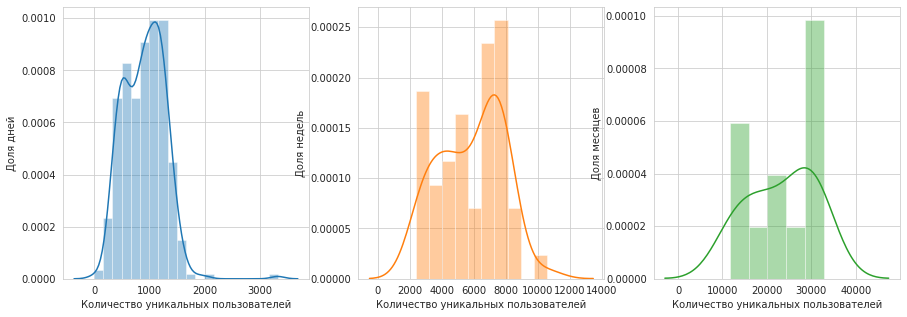

In [24]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
sns.distplot(dau, ax = axes[0], bins = 20, color = plt.cm.tab10(0)).set(xlabel='Количество уникальных пользователей', 
                                                                                 ylabel='Доля дней')
sns.distplot(wau, ax = axes[1], bins = 10, color = plt.cm.tab10(1)).set(xlabel='Количество уникальных пользователей', 
                                                                                  ylabel='Доля недель')
sns.distplot(mau, ax = axes[2], bins = 5, color = plt.cm.tab10(2)).set(xlabel='Количество уникальных пользователей', 
                                                                                  ylabel='Доля месяцев')

Распределение во всех случаях нормальное, выбросов нет. Видно, распределение количества пользователей в большинстве периодов смещено в большую сторону. Возможно, это связано с ростом аудитории в течение периода, чтобы проверить это, строю график количества уникальных пользователей по дням (DAU) в течение года:

[Text(0, 0.5, 'Уникальные пользователи'), Text(0.5, 0, 'Дата')]

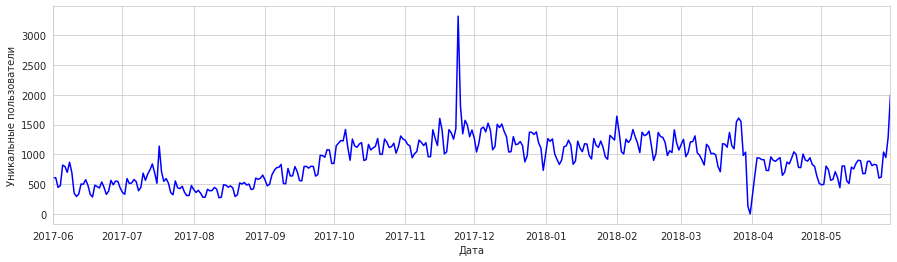

In [25]:
dau.plot(kind='line', figsize = (15,4), color = 'blue').set(xlabel='Дата', ylabel='Уникальные пользователи')

На графике видно увеличение спроса с октября по апрель, а также 2 выделяющихся дня с максимумом и минимумом количества пользователей. Строю распределение по дням недели:

[Text(0, 0.5, 'Уникальные пользователи'), Text(0.5, 0, 'День недели')]

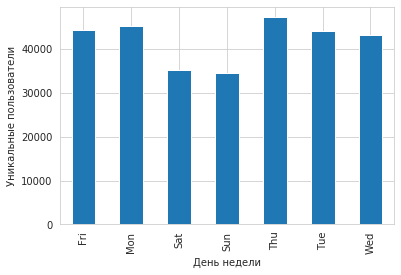

In [26]:
visits['ses_dow'] = visits['start_time'].dt.strftime('%a')
visits.groupby('ses_dow')['uid'].nunique().plot(kind = 'bar').set(xlabel='День недели', ylabel='Уникальные пользователи')

Как мы видим, в выходные люди предпочитают посещать события, а не искать их на Афише, поэтому посетителей меньше. В будние дни количество поситетелей примерно одинаковое.

**Сколько сессий в день?**

Всего среднем сессий в день: 987
Среднее количество сессий на 1 пользователя: 1.09
Только 8% пользователей заходят на Афишу повторно в тот же день , поэтому график количества сессий почти совпадает с графиком уникальных посетителей:


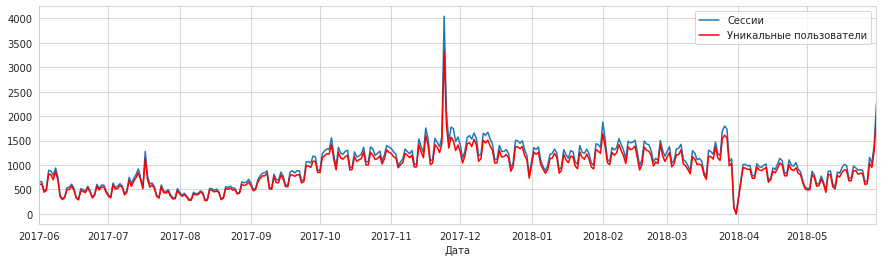

In [27]:
visits.groupby('ses_date')['uid'].count().plot(kind='line', figsize = (15,4)).set(xlabel='Дата')
dau.plot(kind='line', figsize = (15,4), color = 'red').set(xlabel='Дата')
plt.legend(('Сессии', 'Уникальные пользователи'))
print('Всего среднем сессий в день: {:.0f}'.format(visits.groupby('ses_date')['uid'].count().mean()))
ses_per_un_user = visits.groupby('ses_date')['uid'].count().sum() / visits.groupby('ses_date')['uid'].nunique().sum()
print('Среднее количество сессий на 1 пользователя: {:.2f}'.format(ses_per_un_user))
print('Только {:.0%} пользователей заходят на Афишу повторно в тот же день'.format(1-1/ses_per_un_user), 
      ', поэтому график количества сессий почти совпадает с графиком уникальных посетителей:')

**Сколько длится одна сессия?**

In [28]:
print('Среднее время сессии: {0:.0f} сек., медианное: {1:.0f} сек.'.format(
    (visits['ses_length'] / np.timedelta64(1,'s')).mean(),
    (visits['ses_length'] / np.timedelta64(1,'s')).median()))

Среднее время сессии: 643 сек., медианное: 300 сек.


Большинство пользователей проводят на Афише не больше 5 минут, однако за счет длинных сессий среднее время составляет почти 11 минут. На распределении ниже, построенном на основе сессий длиной не больше 30 минут, видно, что мода составляет около минуты. Можно сделать вывод, что большинство пользователей заходит на Афишу только для оформления билета и не задерживается на сайте.

(0, 1800)

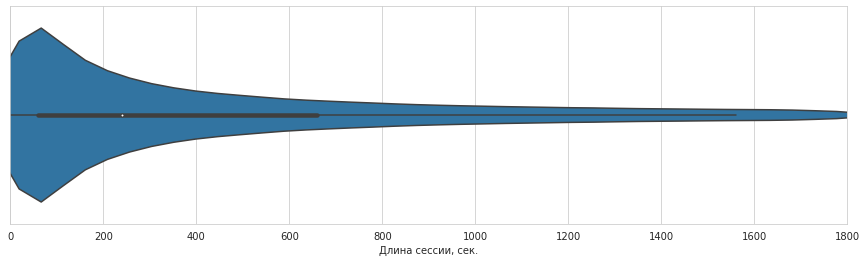

In [29]:
data = (visits['ses_length'] / np.timedelta64(1,'s')).round()
data = data[data <= 1800]
plt.figure(figsize=(15, 4))
ax = sns.violinplot(x = data)
ax.set(xlabel = 'Длина сессии, сек.')
ax.set_xlim(0, 1800)

**Как часто люди возвращаются?**

Строю распределение user retention rate по когортам, сформированным по месяцам от момента первой активности:

In [30]:
visits['session_data'] = visits['start_time'].dt.date
visits['session_week'] = visits['start_time'].dt.week
visits['session_month'] = visits['start_time'].dt.to_period('M')
visits['session_duration'] = visits['end_time'] - visits['start_time']
visits['session_duration'] = visits['session_duration'].apply(lambda x: decimal.Decimal(x.seconds) // 60)
visits['session_duration'] = visits['session_duration'].astype('int')

In [31]:
first_activity_date = visits.groupby('uid')['start_time'].min()
first_activity_date.name = 'first_session_month'
retention = visits.join(first_activity_date,on='uid')
retention['first_session_month'] = retention['first_session_month'].astype('datetime64[M]')
retention['session_month'] = retention['start_time'].astype('datetime64[M]')
retention['cohort_lifetime'] = retention['session_month'] - retention['first_session_month']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1,'M')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')
cohorts = (retention
                           .groupby(['first_session_month', 'cohort_lifetime'])
                           .agg({'uid': 'nunique'})
                           .reset_index())

In [32]:
cohorts

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime']==0][['first_session_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid': 'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime',
                                          values='retention', aggfunc='sum')

In [34]:
visits['c_lifetime'] = ((visits['ses_month'] - visits['fam']) / np.timedelta64(1,'M')).round().astype(int)
cohorts = visits.groupby(['fam','c_lifetime']).agg({'uid':'nunique'}).reset_index()
inital_users_count = cohorts[cohorts['c_lifetime'] == 0][['fam','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(inital_users_count,on='fam')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='fam',columns='c_lifetime',values='retention',aggfunc='sum')
retention_pivot.index = retention_pivot.index.strftime('%Y-%m')

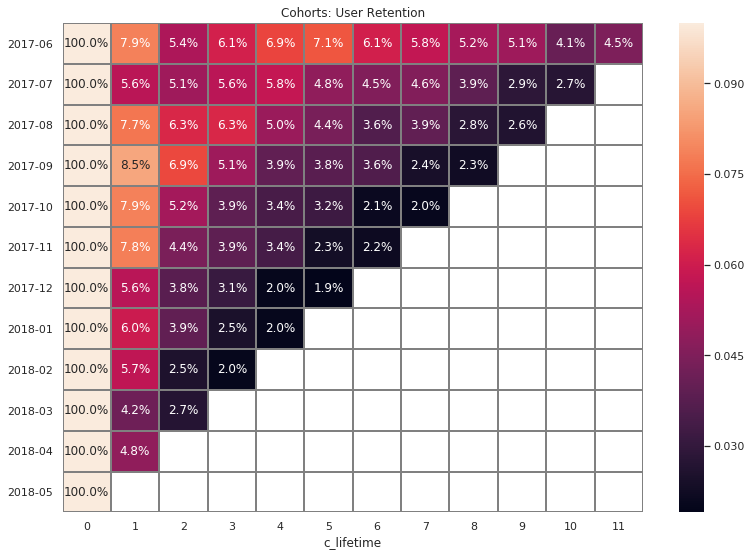

In [35]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1);

График по когортам подтверждает вывод, сделанный раньше: большая часть пользователей использует Афишу только один раз, помесячная метрика retention rate низкая.

[Text(0, 0.5, 'Retention rate'), Text(0.5, 0, 'Время жизни когорты')]

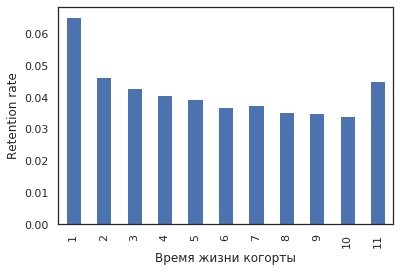

In [36]:
cohorts.groupby('c_lifetime')['retention'].mean()[1:].plot(kind='bar').set(
    xlabel='Время жизни когорты', ylabel='Retention rate')

[Text(0, 0.5, 'Retention rate'), Text(0.5, 0, 'Когорта')]

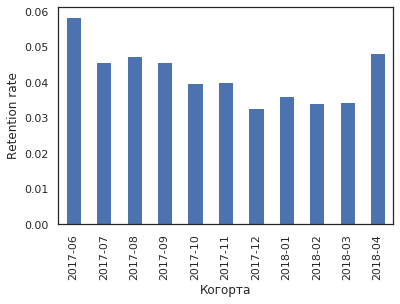

In [37]:
cohorts_retention = cohorts[cohorts['c_lifetime'] != 0].groupby('fam')['retention'].mean()
cohorts_retention.index = cohorts_retention.index.strftime('%Y-%m')
cohorts_retention.plot(kind='bar').set(xlabel='Когорта', ylabel='Retention rate')

In [38]:
retention_pivot_gr = retention_pivot.reset_index()
retention_pivot_gr_6mnth = retention_pivot_gr.iloc[:6, 2:8]
retention_pivot_gr_6mnth
#возьмем для рассчета среднего retention rate период полгода, как наиболее оптимальный и, соответственно, только те когорты, которые прожили уже 
#полные 6 месяцев

c_lifetime,1,2,3,4,5,6
0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015
1,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358
2,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342
3,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860
4,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365
5,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800


In [39]:
mnth_6_retention = retention_pivot_gr_6mnth.mean().mean()*100

In [40]:
"Усредненное значение retantion rate за период 6 месяцев - {:.1f} %".format (mnth_6_retention)

'Усредненное значение retantion rate за период 6 месяцев - 5.2 %'

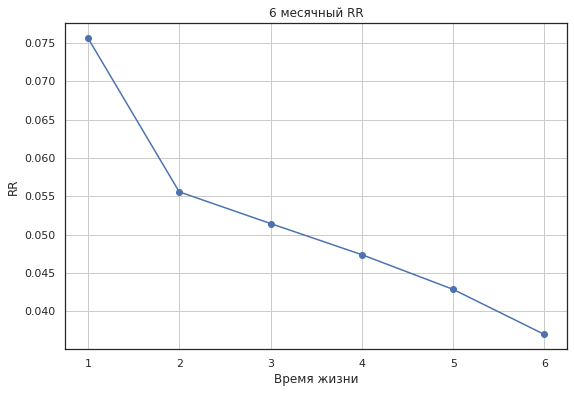

In [41]:
plt.figure(figsize=(9, 6))
plt.title("6 месячный RR")
plt.plot(retention_pivot_gr_6mnth.iloc[:, 0:7].dropna().mean(), linestyle='-', marker='o')
plt.xlabel('Время жизни')
plt.ylabel('RR')
plt.grid(True)
plt.show();

Необходимо отметить, что Retention довольно низкий. Retention второго месяца пользования нашим ресурсом находится в интервале от 6 до 8,5% в зависимости от когорты.Причем после одного месяца пользователя, на второй, возвращается большая часть клиентов, далее, с течением времени, этот процент падает до 2,5-3%.
Это справедливо для всех, кроме самой первой когорты, которая начала пользоваться ресурсом в июне 2017 года. Их Retention тоже довольно низкий, но постоянно находится в "лидерах" по сравнении со всеми остальными когортами.

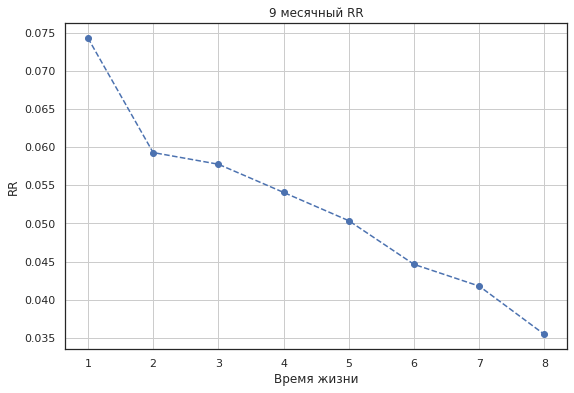

In [42]:
plt.figure(figsize=(9, 6))
plt.title("9 месячный RR")
plt.plot(retention_pivot.iloc[:, 1:9].dropna().mean(), linestyle='--', marker='o')
plt.xlabel('Время жизни')
plt.ylabel('RR')
plt.grid(True)
plt.show();

**Продажи.**

**Когда люди начинают покупать?**

Доля посетителей, которые оформляют заказ:

In [43]:
print('Доля посетителей, оформивших заказ: {:.0%}'.format(orders['uid'].nunique() / visits['uid'].nunique()))

Доля посетителей, оформивших заказ: 16%


Теперь, не учитывая посетителей, не оформивших заказ, составляю таблицу со временем первого посещения и первой покупки для каждого пользователя, а также времени между ними:

In [44]:
first_orders = visits.groupby('uid', as_index = False)['start_time'].min()\
    .merge(orders.groupby('uid', as_index = False)['buy_time'].min(), how = 'inner', on = 'uid')
first_orders.columns = ['uid', 'first_session', 'first_order']
first_orders['start2order'] = first_orders['first_order'] - first_orders['first_session']
first_orders[:1]

,uid,first_session,first_order,start2order
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00


In [45]:
print('Медианное время от первого посещения до заказа: ', first_orders['start2order'].median(), 
      ', среднее время: ', first_orders['start2order'].mean())

Медианное время от первого посещения до заказа:  0 days 00:16:00 , среднее время:  16 days 21:40:10.550064


Половина пользователей делает заказ в течение первых 16 минут, другая может сделать его в следующие сессии в другие дни. Строю гистограмму для покупок тремя частями:

* в течение первого часа после первого посещения,
* в течение первых суток, начиная со второго часа,
* в оставшееся время, начиная со второго дня после первого посещения:


[Text(0, 0.5, 'Доля заказов'),
 Text(0.5, 0, 'Дни со второго дня после начала посещения')]

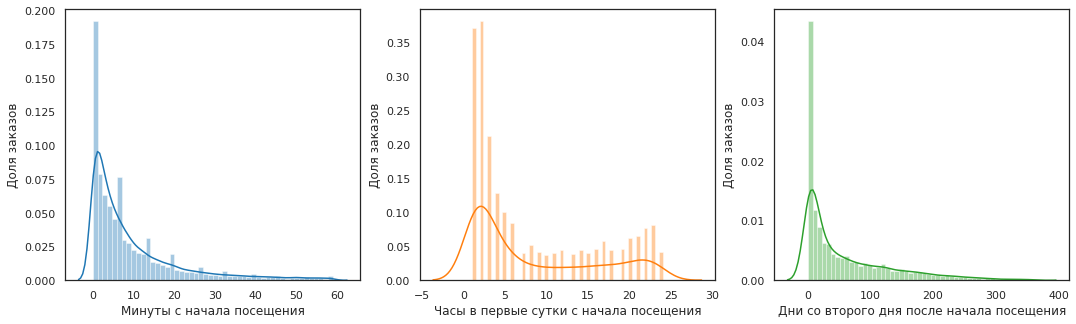

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,5))
sns.distplot((first_orders['start2order'] / np.timedelta64(1,'m')).where(lambda x : x<60).dropna().round(), 
    ax = axes[0], bins = 50, color = plt.cm.tab10(0)).set(xlabel='Минуты с начала посещения', ylabel='Доля заказов')
sns.distplot((first_orders['start2order'] / np.timedelta64(1,'h')).where(lambda x : x<=24).where(lambda x : x>1).dropna().round(), 
    ax = axes[1], bins = 50, color = plt.cm.tab10(1)).set(xlabel='Часы в первые сутки с начала посещения', ylabel='Доля заказов')
sns.distplot((first_orders['start2order'] / np.timedelta64(1,'D')).where(lambda x : x>=1).dropna().round(), 
    ax = axes[2], bins = 50, color = plt.cm.tab10(2)).set(xlabel='Дни со второго дня после начала посещения', ylabel='Доля заказов')

По графикам можно сделать выводы о том, что:

* на дневном графике заметно увеличение заказов в районе 20-24 часов: это пользователи, не оформившие заказ накануне, примерно в это же время на следующий день возвращаются к сервису, чтобы оформить заказ;
* значительная часть пользователей совершает заказ в первую минуту после захода на Афишу; это те пользователи, которые зашли на Афишу только оформить покупку билетов на мероприятие, которое они уже выбрали вне Афиши. Эти же пользователи формируют медианное время сессии на сайте в 5 минут;
* далее, за исключением отдельных пиков, распределение убывающее, что было понятно из медианного времени от захода до заказа в 16 минут;

In [47]:
first_orders['fom'] = first_orders['first_order'].astype('datetime64[M]')
first_orders['fam'] = first_orders['first_session'].astype('datetime64[M]')
first_orders['c_lifetime'] = ((first_orders['fom'] - first_orders['fam']) / np.timedelta64(1,'M')).round().astype(int)

In [48]:
cohorts = first_orders.groupby(['fam','c_lifetime']).agg({'uid':'nunique'}).reset_index()
cohort_users_count = cohorts.groupby('fam')['fam','uid'].sum()
cohort_users_count = cohort_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(cohort_users_count,on='fam')
cohorts['order_share'] = cohorts['uid']/cohorts['cohort_users']
order_pivot = cohorts.pivot_table(index='fam',columns='c_lifetime',values='order_share',aggfunc='sum')
order_pivot.index = order_pivot.index.strftime('%Y-%m')

Text(66.5, 0.5, 'Когорта пользователей по первой активности')

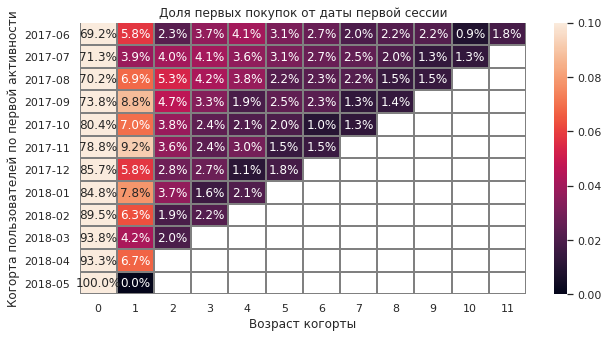

In [49]:
plt.figure(figsize=(10, 5))
plt.title('Доля первых покупок от даты первой сессии')
ax = sns.heatmap(order_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0, vmax = 0.1)
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей по первой активности')

Увеличение доли покупок в нулевой месяц каждой следующей когорты происходит из-за того, что в график не включены пользователи, еще не совершившие свой заказ. Поэтому нужно анализировать долю покупок в каждый месяц жизни (возраст) когорт. Здесь видно, что доля покупок в последующие месяцы постепенно снижается: у первых когорт значения для каждого соответсвующего месяца жизненного цикла в среднем выше, чем у следующих когорт. Это говорит о том, что все большее количество пользователей совершают заказ в первый месяц посещения Афиши, а не спустя некоторое время, что можно считать положительным изменением продукта.

**Сколько раз покупают за период?**

In [50]:
dau_buy = orders.groupby('buy_time_day').agg({'uid': 'nunique'}).mean().round().astype('int')
wau_buy = orders.groupby(['buy_time_year', 'buy_time_week']).agg({'uid': 'nunique'}).mean().round().astype('int')
mau_buy = orders.groupby(['buy_time_year', 'buy_time_month']).agg({'uid': 'nunique'}).mean().round().astype('int')

print('Среднее колличество людей, которые покупают продукт, в день:', dau_buy)
print('Среднее колличество людей, которые покупают продукт, в неделю:', wau_buy)
print('Среднее колличество людей, которые покупают продукт, в месяц:', mau_buy)

Среднее колличество людей, которые покупают продукт, в день: uid    128
dtype: int64
Среднее колличество людей, которые покупают продукт, в неделю: uid    817
dtype: int64
Среднее колличество людей, которые покупают продукт, в месяц: uid    3155
dtype: int64


In [51]:
orders = orders.merge(first_orders.groupby('uid')['fom'].min(), on = 'uid', how = 'left')
new_orders = orders.groupby(['uid', 'fom'], as_index = False)['revenue'].count()
new_orders = new_orders.groupby('fom', as_index = False).agg({'uid':'count','revenue':'sum'})
new_orders['orders_per_user'] = new_orders['revenue'] / new_orders['uid'] 
new_orders['months'] = (new_orders['fom'].max() - new_orders['fom'])/np.timedelta64(1,'M')
new_orders['months'] = new_orders['months'].round()
new_orders['orders_per_user_per_month'] = (new_orders['orders_per_user'] - 1)/new_orders['months']
new_orders['fo_month'] = new_orders['fom'].dt.strftime('%b')
new_orders

,fom,uid,revenue,orders_per_user,months,orders_per_user_per_month,fo_month
0,2017-06-01,2023,4438,2.193772,12.0,0.099481,Jun
1,2017-07-01,1923,2910,1.513261,11.0,0.046660,Jul
2,2017-08-01,1370,2188,1.597080,10.0,0.059708,Aug
3,2017-09-01,2581,3878,1.502518,9.0,0.055835,Sep
4,2017-10-01,4340,6005,1.383641,8.0,0.047955,Oct
5,2017-11-01,4081,5900,1.445724,7.0,0.063675,Nov
6,2017-12-01,4383,5894,1.344741,6.0,0.057457,Dec
7,2018-01-01,3373,4308,1.277201,5.0,0.055440,Jan
8,2018-02-01,3651,4470,1.224322,4.0,0.056081,Feb
9,2018-03-01,3533,4484,1.269176,3.0,0.089725,Mar


In [52]:
print('Несмотря на то, что в датасете есть данные только за 12 месяцев,', 
      'показатель времени между покупками можно представить следующим образом:')
print('В среднем, пользователь совершает второй заказ через',
      (1/new_orders['orders_per_user_per_month'].mean()).round(0).astype(int),
     'месяцев после первого.')

Несмотря на то, что в датасете есть данные только за 12 месяцев, показатель времени между покупками можно представить следующим образом:
В среднем, пользователь совершает второй заказ через 15 месяцев после первого.


**Какой средний чек?**

Text(66.5, 0.5, 'Когорта пользователей по первому заказу')

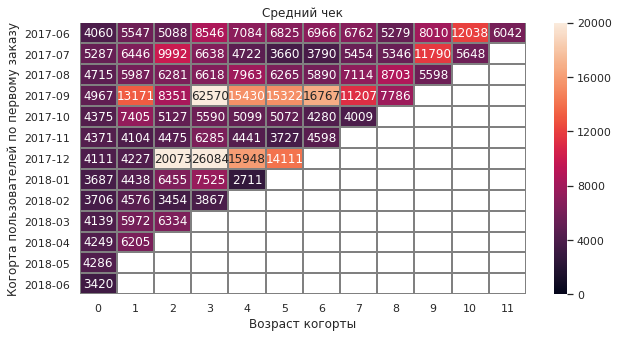

In [53]:
orders['c_lifetime'] = ((orders['buy_month'] - orders['fom']) / np.timedelta64(1,'M')).round().astype(int)
order_pivot = orders.pivot_table(index='fom',columns='c_lifetime',values='revenue',aggfunc='mean')
order_pivot.index = order_pivot.index.strftime('%Y-%m')
plt.figure(figsize=(10, 5))
plt.title('Средний чек')
ax = sns.heatmap(order_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray', vmin = 0, vmax = 20000)
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей по первому заказу')

In [54]:
orders.head()

,buy_time,revenue,uid,day,buy_time_day,buy_time_week,buy_time_month,buy_time_year,buy_month,fam,fom,c_lifetime
0,2017-06-01 00:10:00,17000,10329302124590727494,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,550,11627257723692907447,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,370,17903680561304213844,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,550,16109239769442553005,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,370,14200605875248379450,2017-06-01,2017-06-01,22,6,2017,2017-06-01,2017-06-01,2017-06-01,0


Так как когорты отсчитываются от месяца первой покупки, нулевой месяц основан на большем количестве данных и поэтому ближе к среднему. Следующие (1-12) месяцы содержат больше отклонений за счет большего веса единичных покупок, например, более высоким средним чеком сразу в нескольких месяцах выделяются когорты сентября и декабря 2017 года.
Единичные покупки влияют на средний чек и делают сравнение нерепрезентативным. Чтобы отследить тренд изменения среднего чека по когортам, я отсекаю покупки свыше 95% перцентиля, и сравниваю средний чек для каждой когорты:

In [55]:
avg_order = orders.groupby('fom',as_index = False)['revenue'].mean()[:12]
avg_order['fom'] = avg_order['fom'].dt.strftime('%b')
avg_order_90 = orders[orders['revenue'] < orders['revenue'].quantile(.95)].groupby('fom',as_index = False)['revenue'].mean()[:12]
avg_order_90['fom'] = avg_order_90['fom'].dt.strftime('%b')

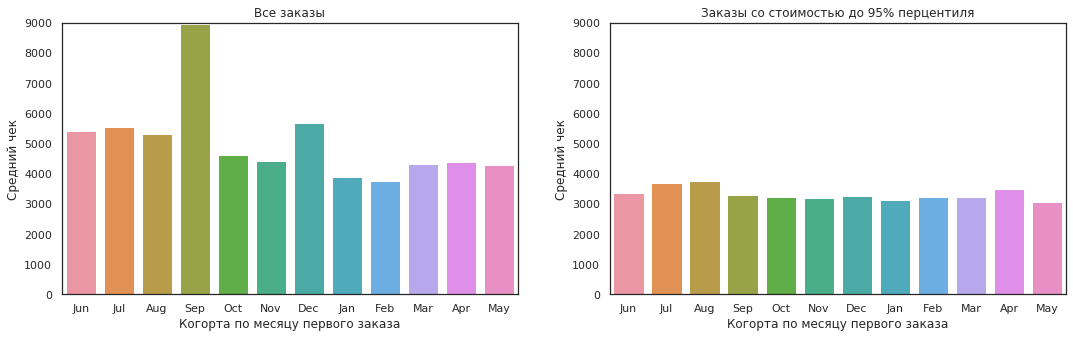

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,5))
sns.barplot(x="fom", y="revenue", data=avg_order, ax = axes[0])\
        .set(xlabel='Когорта по месяцу первого заказа', ylabel='Средний чек', title = 'Все заказы')
sns.barplot(x="fom", y="revenue", data=avg_order_90, ax = axes[1])\
        .set(xlabel='Когорта по месяцу первого заказа', ylabel='Средний чек', title = 'Заказы со стоимостью до 95% перцентиля')
axes[0].set_ylim(0, 9000)
axes[1].set_ylim(0, 9000)
plt.show()

Графики по полным данным и без учета 5% самых дорогих заказов отличаются. Исходя из них, можно сделать выводы:

* несмотря на постепенное снижение среднего чека по полным данным, очищенные от 5% самых дорогих заказов данные показывают, что он почти не меняется в течение периода;
* в течение рассматриваемого периода на Афишу стало приходить меньше покупателей, делающих дорогие заказы. Это негативно влияет на выручку, но не обязательно означает ухудшения качества продукта: например, возможно, что сервис не направлен на привлечение таких покупателей, большие покупки являются случайными и неконтролируемыми и оценивать средний чек нужно по усредненным данным. Если привлечение покупателей с крупными покупками можно контролировать, то налицо негативная динамика этого показателя.

**Сколько денег приносят? (LTV)**

In [57]:
cohorts = orders.groupby(['fom','buy_month'], as_index = False)['revenue'].sum()
cohorts = cohorts.merge(new_orders[['fom', 'uid']], on = 'fom')
cohorts['age'] = (cohorts['buy_month'] - cohorts['fom']) / np.timedelta64(1, 'M')
cohorts['age'] = cohorts['age'].round().astype(int)
cohorts['ltv'] = cohorts['revenue'] / cohorts['uid'] #ltv = выручка в пересчете на пользователя
cohorts = pd.merge(cohorts, 
                   costs.groupby('cost_month', as_index = False)['costs'].sum(), 
                   left_on='fom', right_on='cost_month', how = 'left')
cohorts['cac'] = cohorts['costs'] / cohorts['uid'] #cac = расходы в пересчете на пользователя
cohorts['romi'] = cohorts['ltv'] / cohorts['cac']
cohorts.head()

,fom,buy_month,revenue,uid,age,ltv,cost_month,costs,cac,romi
0,2017-06-01,2017-06-01,9557490,2023,0,4724.414236,2017-06-01,18014997.0,8905.089965,0.530530
1,2017-06-01,2017-07-01,981820,2023,1,485.328720,2017-06-01,18014997.0,8905.089965,0.054500
2,2017-06-01,2017-08-01,885340,2023,2,437.637173,2017-06-01,18014997.0,8905.089965,0.049145
3,2017-06-01,2017-09-01,1931300,2023,3,954.671280,2017-06-01,18014997.0,8905.089965,0.107205
4,2017-06-01,2017-10-01,2068580,2023,4,1022.530895,2017-06-01,18014997.0,8905.089965,0.114825


Накопительный LTV по когортам:

In [58]:
ltv = cohorts.pivot_table(index='fom', columns='age', values='ltv', aggfunc='mean').round()
ltv.cumsum(axis=1).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
fom,,,,,,,,,,,,
2017-06-01,4724.0,5209,5647,6602,7625,8361,9311,9893,10446,11052,11623,11880
2017-07-01,6010.0,6345,6969,7328,7505,7661,7781,7923,8084,8231,8387,
2017-08-01,5277.0,5749,6207,6598,7092,7376,7587,7992,8284,8472,,
2017-09-01,5645.0,6763,7284,11260,11661,12308,13010,13253,13437,,,
2017-10-01,5004.0,5540,5731,5888,6040,6160,6245,6360,,,,
2017-11-01,5155.0,5554,5754,6079,6227,6281,6396,,,,,
2017-12-01,4738.0,4998,5923,6988,7301,7639,,,,,,
2018-01-01,4136.0,4431,4735,4878,4941,,,,,,,
2018-02-01,4157.0,4435,4514,4588,,,,,,,,


Дополнительных комментариев не нужно, так как эта таблица, с учетом того, что количество покупок на пользователя стремится к единице, по сути аналогична накопительным данным по среднему чеку. Данные по LTV будут проанализированы применительно к ROMI.

**Маркетинг.**

**Сколько денег потратили? Всего / на каждый источник / по времени.**

In [59]:
print('Потратили всего денег:', costs['costs'].sum())

Потратили всего денег: 329131595


In [60]:
print('Потратили денег на каждый источник:')
print(costs.groupby('source_id').agg({'costs': 'sum'}))

Потратили денег на каждый источник:
               costs
source_id           
1           20833266
2           42806036
3          141321629
4           61073595
5           51757095
9            5517484
10           5822490


In [61]:
def grafik(data):
    data.plot(x = 'costs_date_month',
           y = 'costs',
           style = 'o-',
           figsize = (15, 7),
           ax = ax,
           grid = True,
           legend = True)

In [62]:
costs_month = costs.groupby(['source_id', 'costs_date_month']).agg({'costs': 'sum'}).reset_index()

In [63]:
costs_by_month_cumulative = costs.pivot_table(index = 'cost_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')\
                                            .cumsum(axis = 1).reset_index()
costs_by_month_cumulative['cost_month'] = costs_by_month_cumulative['cost_month'].dt.strftime('%b')

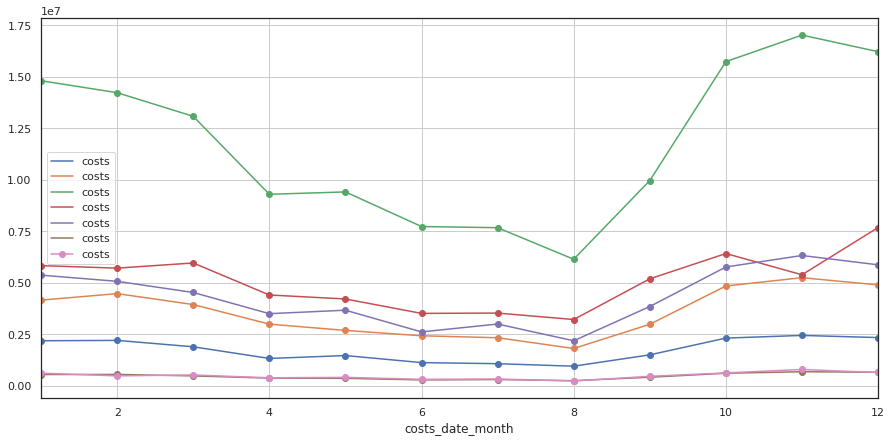

In [64]:
fig, ax = plt.subplots()    
for i in costs_month['source_id'].unique():
    grafik(costs_month.query('source_id == @i'))

<a class="anchor" id="3-bullet"></a>

Расходы на привлечение увеличивались в сентябре-декабре 2017 года, а затем постепенно снижались до мая 2018. Соотношение расходов на отдельные источники сохранялось почти без изменений. Больше всего расходов приходится на источник №3.

Суммарные расходы за все время по видам источников:

In [65]:
cost_by_source = costs.groupby('source_id', as_index = False)['costs'].sum()\
    .sort_values(by = 'costs', ascending = False).reset_index(drop = True)
cost_by_source = cost_by_source.append(pd.DataFrame([['total', costs['costs'].sum()]], columns = ['source_id', 'costs']))
cost_by_source['%_of_total'] = cost_by_source['costs'] / costs['costs'].sum()
cost_by_source

,source_id,costs,%_of_total
0,3,141321629,0.429377
1,4,61073595,0.185560
2,5,51757095,0.157253
3,2,42806036,0.130058
4,1,20833266,0.063298
5,10,5822490,0.017690
6,9,5517484,0.016764
0,total,329131595,1.000000


**Сколько стоило привлечение одного покупателя из каждого источника?**

Составим таблицу по количеству покупателей, привлеченных из каждого источника по месяцам:

In [66]:
users = visits[['uid', 'source_id', 'start_time', 'fam']]
first_visit = visits.groupby('uid', as_index = False)['start_time'].min()
first_visit.columns = ['uid', 'fat'] #fat = first activity time
users = users.merge(first_visit, on = 'uid')
users = users[users['start_time'] == users['fat']] #оставляю записи только с первым посещением
users = users.merge(orders.groupby('uid', as_index = False)['revenue'].sum(), on = 'uid', how = 'left') #добавляю выручку
users = users.dropna().reset_index(drop = True) #оставляю записи только по покупателям с выручкой
users.head()

,uid,source_id,start_time,fam,fat,revenue
0,16174680259334210214,4,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:05:00,2330.0
1,16007536194108375387,5,2017-09-03 21:35:00,2017-09-01,2017-09-03 21:35:00,5500.0
2,8056418121947262981,2,2017-06-04 14:17:00,2017-06-01,2017-06-04 14:17:00,466570.0
3,18188358787673499603,3,2018-02-10 12:17:00,2018-02-01,2018-02-10 12:17:00,790.0
4,2307401184189569202,4,2017-09-23 23:27:00,2017-09-01,2017-09-23 23:27:00,3670.0


Считаю стоимость привлечения покупателя из каждого источника и CAC:

In [67]:
sources = users.groupby(['source_id', 'fam'], as_index = False).agg({'uid':'count', 'revenue':'sum'})
sources.columns = ['source_id', 'cost_month', 'users', 'revenue']
sources = sources.merge(costs.groupby(['source_id', 'cost_month'],as_index = False)['costs'].sum(), 
                        on = ['source_id', 'cost_month'])
sources['cac'] = sources['costs'] / sources['users']
sources['romi'] = sources['revenue'] / sources['costs']
sources['month'] = sources['cost_month'].dt.strftime('%b%y')
sources.head()

,source_id,cost_month,users,revenue,costs,cac,romi,month
0,1,2017-06-01,240,9910688.0,1125610,4690.041667,8.804726,Jun17
1,1,2017-07-01,184,2341210.0,1072879,5830.864130,2.182175,Jul17
2,1,2017-08-01,126,2624270.0,951808,7554.031746,2.757142,Aug17
3,1,2017-09-01,248,2414970.0,1502010,6056.491935,1.607826,Sep17
4,1,2017-10-01,350,3252300.0,2315750,6616.428571,1.404426,Oct17


Text(66.5, 0.5, 'Месяц расходов и когорта пользователей')

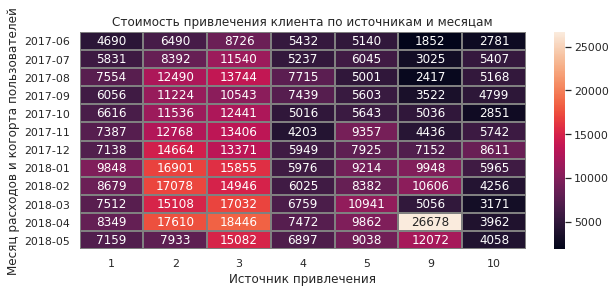

In [68]:
sources_pivot = sources.pivot_table(index='cost_month', columns='source_id', values='cac', aggfunc = 'sum')
sources_pivot.index = sources_pivot.index.strftime('%Y-%m')
plt.figure(figsize=(10, 4))
plt.title('Стоимость привлечения клиента по источникам и месяцам')
ax = sns.heatmap(sources_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
ax.set_xlabel('Источник привлечения')
ax.set_ylabel('Месяц расходов и когорта пользователей')

За отдельными исключениями, стоимость привлечения клиента растет со временем. При этом разница между месяцами не так велика, как между разными источниками: источники 2 и 3 значительно дороже остальных.

**Насколько окупились расходы?**

Построим визуализацию ROMI по когортам. Очевидно, что у Афиши валовая прибыль находится на уровне нескольких процентов, а не всей суммы выручки, но, так как этих данных нет в условии, считаем ROMI на основе полной выручки:

Text(66.5, 0.5, 'Когорта пользователей')

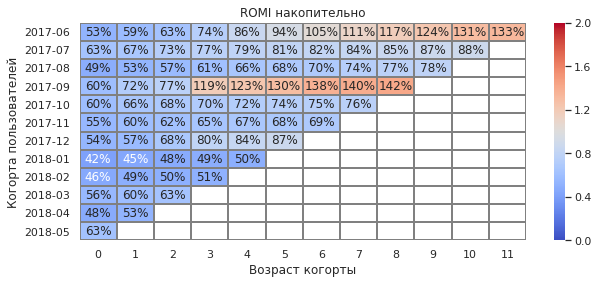

In [69]:
cohorts_romi = cohorts.pivot_table(index='fom', columns='age', values='romi', aggfunc='mean')
cohorts_romi.index = cohorts_romi.index.strftime('%Y-%m')
plt.figure(figsize=(10, 4))
plt.title('ROMI накопительно')
ax = sns.heatmap(cohorts_romi.cumsum(axis=1), annot=True, fmt='.0%', 
                 linewidths=1, linecolor='gray', vmin=0, vmax=2, cmap="coolwarm")
ax.set_xlabel('Возраст когорты')
ax.set_ylabel('Когорта пользователей')

На графике положительный (>100%) ROMI отмечен теплым цветом. Как видно, окупилось только две когорты от июня и сентября, причем быстрее всего - сентябрьская. Важно то, что тренд прироста ROMI от месяца к месяцу для последних пяти когорт показывает, что прирост выручки почти прекратился и они, вероятно, не окупятся никогда.

Также построим анализ ROMI по источникам привлечения с разбивкой по когортам:

Text(66.5, 0.5, 'Месяц расходов и когорта пользователей')

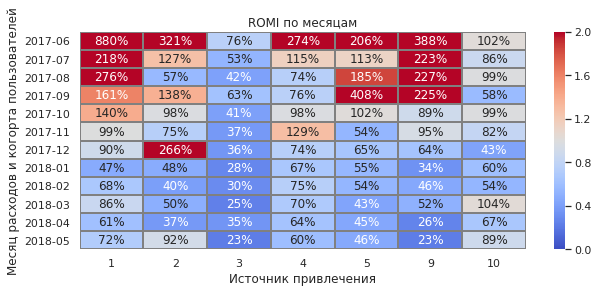

In [70]:
romi_pivot = sources.pivot_table(index='cost_month', columns='source_id', values='romi', aggfunc = 'mean')
romi_pivot.index = romi_pivot.index.strftime('%Y-%m')
plt.figure(figsize=(10, 4))
plt.title('ROMI по месяцам')
ax = sns.heatmap(romi_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray', vmin=0, vmax=2, cmap="coolwarm")
ax.set_xlabel('Источник привлечения')
ax.set_ylabel('Месяц расходов и когорта пользователей')

Общий цвет графика явно говорит о том, что расходы на привлечение пока не окупились для большинства когорт и источников.

Также построим ROMI только по источникам, без разделения по когортам:

[Text(0, 0.5, 'ROMI'),
 Text(0.5, 0, 'Источник привлечения'),
 Text(0.5, 1.0, 'ROMI по источникам привлечения')]

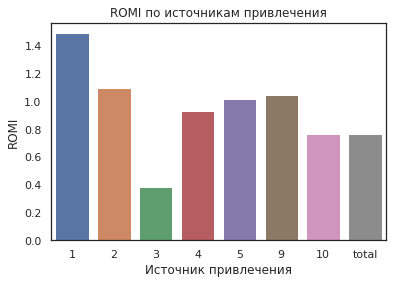

In [71]:
romi_sources = sources.groupby('source_id', as_index = False).agg({'revenue':'sum', 'costs':'sum'})
romi_sources = romi_sources.append(pd.DataFrame([['total', romi_sources['revenue'].sum(), romi_sources['costs'].sum()]]
                                                , columns = ['source_id', 'revenue', 'costs']))
romi_sources['romi'] = romi_sources['revenue'] / romi_sources['costs']
sns.barplot(x="source_id", y="romi", data=romi_sources)\
        .set(xlabel='Источник привлечения', ylabel='ROMI', title = 'ROMI по источникам привлечения')

Выводы:
* общий ROMI равен 77%, то есть маркетинговые расходы не окупаются, что было видно из предыдущих графиков;
* ROMI выше единицы, который формально говорит о том, что источник окупился, у 4 источников из 7, но только у источника №1 значительно превышает 100%;
* при этом результаты источников №№ 1, 5, 9 не очень показательны за счет низкой базы;
* как уже было отмечено раньше, когорты от июня, сентября и декабря прибыльнее других, однако декабрьская - за счет отдельных крупных покупок, которые могут и не повториться в будущем;
* без абсолютных данных нельзя однозначно говорить об эффективности маркетинга.

Чтобы определить общий финансовый результат, построим графики доходов и расходов по времени:

In [72]:
profit = orders.groupby('buy_month', as_index = False)['revenue'].sum().merge(
         costs.groupby('cost_month', as_index = False)['costs'].sum(), left_on='buy_month', right_on='cost_month')
del profit['cost_month']
profit.columns = ['month','revenue','costs']
profit['profit'] = profit['revenue'] - profit['costs']
profit['month'] = profit['month'].dt.strftime('%b%y')
profit

,month,revenue,costs,profit
0,Jun17,9557490,18014997,-8457507
1,Jul17,12539470,18240587,-5701117
2,Aug17,8758780,14790536,-6031756
3,Sep17,18345509,24368909,-6023400
4,Oct17,27987697,36322880,-8335183
5,Nov17,27069927,37907880,-10837953
6,Dec17,36388593,38315347,-1926754
7,Jan18,19417129,33518515,-14101386
8,Feb18,25560537,32723028,-7162491
9,Mar18,28834586,30415270,-1580684


Text(0, 0.5, 'Сумма, млн. руб.')

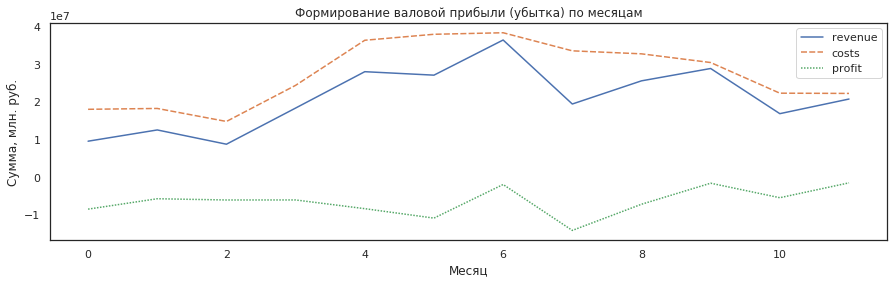

In [73]:
plt.figure(figsize=(15, 4))
ax = sns.lineplot(data = profit.iloc[:,1:4])
ax.set_title('Формирование валовой прибыли (убытка) по месяцам')
ax.set_xlabel('Месяц') 
ax.set_ylabel('Сумма, млн. руб.')

* график подтверждает выводы, сделанные по ROMI: в абсолютных значениях маркетинговые расходы не окупаются даже полной выручкой, хотя в некоторые месяцы они почти сравниваются; валовая прибыль отрицательна;
* следует учитывать, что он включает в себя все понесенные расходы, но не всю будущую выручку, которая ожидается от привлеченных пользователей. Если учесть постепенное сокращение убытка и будущие доходы, можно ожидать, что при прекращении привлечения новых пользователей валовая прибыль в отдельные периоды может выйти в плюс (не накопительно);
* объем расходов и выручки сильно коррелируют. Учитывая, что большая часть выручки приходится на первый месяц, можно говорить о том, что выручка прямо зависит от расходов на маркетинг в каждый отдельный месяц, и при сокращении маркетинговых расходов сразу снижается, то есть маркетинг не действует на пользователей в следующие месяцы.

**Как эти метрики отличаются по устройствам?**

In [74]:
users_devices = visits.pivot_table(index = 'uid', columns = 'device', values = 'source_id', aggfunc = 'count')
data = {'device': ['ПК', 'Мобильные', 'Оба'], 
     'users': [len(users_devices.query('desktop == desktop')), 
               len(users_devices.query('touch == touch')), 
               len(users_devices.query('desktop == desktop and touch == touch'))]}
users_devices_sum = pd.DataFrame(data=data)
users_devices_sum = users_devices_sum.set_index('device')
summary = users_devices_sum.values.sum()

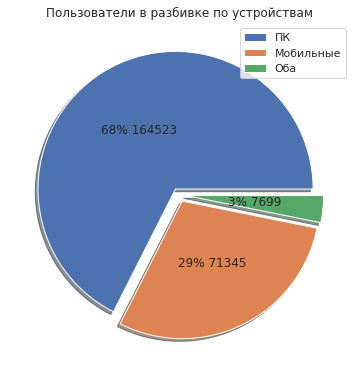

In [75]:
def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.0f}% {:.0f}".format(pct, value)
ax_pie = users_devices_sum.plot(kind='pie', y='users', fontsize=12, use_index=False, shadow=True, explode = (0.05, 0.05, 0.05),
                        title = 'Пользователи в разбивке по устройствам', pctdistance=0.5, figsize=(15,5), 
                        autopct=lambda pct: func_pct(pct), labels=None)
plt.tight_layout(pad=0)
y_label = ax_pie.set_ylabel('')

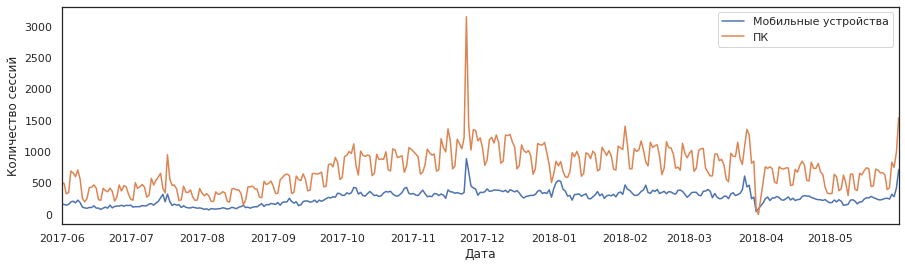

In [76]:
visits[visits['device'] == 'touch'].groupby('ses_date')['uid'].count()\
            .plot(kind='line', figsize = (15,4)).set(xlabel='Дата', ylabel='Количество сессий')
visits[visits['device'] == 'desktop'].groupby('ses_date')['uid'].count()\
            .plot(kind='line', figsize = (15,4)).set(xlabel='Дата', ylabel='Количество сессий')
plt.legend(('Мобильные устройства', 'ПК'))

In [77]:
print('Доля сессий мобильных пользователей: {:.0%}'.format(len(visits[visits['device'] == 'touch']) / len(visits)))

Доля сессий мобильных пользователей: 27%


Как следует из графика, соотношение долей пользователей на мобильных и стационарных устройствах примерно постоянно. Единственная разница - в том, что мобильная аудитория меньше подтвержена колебаниям по дням недели. Вероятно, часть пользователей заходит на Афишу с рабочих компьютеров в будние. Можно считать, что аудитории схожи. Доля посещений с мобильного (27%) почти равна доле пользователей мобильных устройств (29%), то есть разницы в уровне активности пользователей также нет.

In [78]:
print(f'Среднее время сессии: с мобильного - {0:.0f} сек., с ПК - {1:.0f} сек.',
      f'Медианное время: с мобильного - {2:.0f} сек., с ПК - {3:.0f} сек.'.format(
    (visits[visits['device'] == 'touch']['ses_length'] / np.timedelta64(1,'M')).mean(),
    (visits[visits['device'] == 'desktop']['ses_length'] / np.timedelta64(1,'M')).mean(),
    (visits[visits['device'] == 'touch']['ses_length'] / np.timedelta64(1,'M')).median(),
    (visits[visits['device'] == 'desktop']['ses_length'] / np.timedelta64(1,'M')).median()))

Среднее время сессии: с мобильного - 0 сек., с ПК - 1 сек. Медианное время: с мобильного - 2 сек., с ПК - 3 сек.


# Выводы.

Валовая прибыль Афиши отрицательна (для валовой прибыли в данном случае я считаю маркетинговые расходы себестоимостью). Такая ситуация нормальна в нескольких случаях, например, когда маркетинг направлен на рост и поэтому доходы не догоняют маркетинговые расходы; при долгой окупаемости проекта, когда есть уверенность, что LTV окупит маркетинг на будущем этапе; или когда валовая прибыль не является целью, так как цель проекта в сборе данных или ожидается изменение монетизации, которое окупит вложенное. В данном случае прирост выручки явно незначительный, эффект от маркетинговых расходов явно краткосрочный, а LTV клиента в основном сосредоточена в первой покупке. Значит, или валовая прибыль не является целью Афиши на данном этапе, или маркетинговая стратегия должна быть изменена, чтобы достичь окупаемости.

В целом, можно остановиться на выводе о том, что на текущий момент маркетинг не окупается практически на всех источниках и периодах, однако нет данных для принятия решения о необходимости исправления ситуации.

Обязательно сделать упор на аудитории мобильных устройств!

Доля пользователей с мобильных платформ достаточно низкая для 2017-18 гг.: 27%, при этом аудитории мобильных устройств и ПК не отличаются.